# Polynomial Regression on Riemannian Manifolds

# I. Introduction

In this notebook, we aim to demonstrate Riemannian polynomial regression in Kendall shape space. The applications are limitless, ranging from rigid and non-rigid kinematics to the shape change of organs due to growth and aging. This is what we aim to achieve here -- the ability to study rat skull growth data and make inferences on new samples. 

Classical regression suffers from the limitation that the data must be in Euclidean space. Learning on Euclidean space introduces scale and rotation whereas in intrinsic regression, this is not present. The analysis of transformation and shape are best represented as elements of Riemannian manifolds. The paper presents fitting polynomial regression curves on a general Riemannian manifold using intrinsic methods without the need for unwrapping and rolling.

I tried to find papers related to this topic, but surprisingly enough, there aren't that many. Here are a few:

1. W. T. Zaw and T. T. Naing, "Modeling of Rainfall Prediction over Myanmar Using Polynomial Regression," 2009 International Conference on Computer Engineering and Technology, 2009, pp. 316-320, doi: 10.1109/ICCET.2009.157.
    
This paper tried to fit a model to predict rainfall in the coming days. Similar to rat skulls which do not grow in a linear trend, rainfall also follows a fluctuating pattern across months. In order to capture this, they fit a polynomial regression model which can represent the data better.

2. H. Niu, Q. Lu and C. Wang, "Color Correction Based on Histogram Matching and Polynomial Regression for Image Stitching," 2018 IEEE 3rd International Conference on Image, Vision and Computing (ICIVC), 2018, pp. 257-261, doi: 10.1109/ICIVC.2018.8492895.

This paper used polynomial regression for a small task among many. In order to perform color correction, they use the color components of the overlapping areas in the image and the result of the histogram matching operation, and apply polynomial regression to determine the relationship between the two. They are basically using least squares to solve the problem. This is another unique example of the use of polynomial regression in applications.

3. O. Attallah, H. Gadelkarim and M. A. Sharkas, "Detecting and Classifying Fetal Brain Abnormalities Using Machine Learning Techniques," 2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA), 2018, pp. 1371-1376, doi: 10.1109/ICMLA.2018.00223.

This paper tried to detect abnormalities in fetal brain for early diagnosis and treatment planning. Our paper covered rat skull brain, while this paper discussed human brains. A key difference is that this paper does not do any manifold learning or shape analysis -- data is kept within the Euclidean space and classical machine learning algorithms are fit on it.

# II. Background and Model

The model is a Riemannian polynomial regression in Kendall shape space.

Let $ (M,g) $ represent a Riemannian manifold. For every point $ p \in M $, the metric $g$ determines an inner product on the tangent space $ T_p M $. The exponential map $ Exp_p : T_p M -> M $ is the mapping from the tangent space at $p$ into the manifold. The logarithm map of $q$ at $p$ denoted by $ v = Log_p q $ is the mapping of points q to their asosciated tangent vectors $v$ at $p$.

The Riemannian polynomial equations cannot be solved in closed form, and must be integrated numerically. We can use an integrator, and at each step of the integrated, each vector is incremented within the tangent space at $ \gamma(t) $ and the results are parallel transported infinitesimally along a geodesic from $ \gamma(t) $ to $ \gamma(t + \Delta t) $. To integrate a polynomial forward in time, you only need the exponential map and parallel transport on the manifold.

To indicate how well the model fits a set of data, we compute the coefficient of determination of the regression polynomial $ \gamma(t) $, denoted by $ R^2 $. It is a function of the total variance and the sum of squared error, defined as $ R^2 = 1 - \frac{SSE}{Var} $. The value will be between 0 and 1, where 1 is a perfect fit. It can be negative because the model can be arbitrarily worse.


The paper uses Brookstein's classical rat skull growth dataset. The data consists of 8 landmarks on a midsagittal section of rat calivaria (upper skulls). Landmark positions are available for 18 rats and at 8 ages apiece. The link in the paper led to a dead page and I could not find the dataset online, so I resorted to using the dataset we looked at in class. This was Vilmann's rat calvaria (skulls excluding the lower jaw) from X-ray images. This data has 8 landmarks in 2D for each shape, for 18 individuals at 8 different time points: ages 7, 14, 21, 30, 40, 60, 90, and 150 days. This has the exact same number of samples as the Brookstein dataset, so I'm starting to wonder if they are referring to the same thing. Riemannian polynomials of orders k = 0, 1, 2, 3 were fit to this data.

# III. Implementation (of Elementary Operations)

In [1]:
# imports and set up environment
!pip install geomstats
!pip install autograd
import os
os.environ["GEOMSTATS_BACKEND"] = "autograd"
import geomstats

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import geomstats.backend as gs
import geomstats.visualization as viz
from geomstats.geometry.pullback_metric import PullbackMetric
from pre_shape_autodiff import PreShapeSpace, KendallShapeMetric
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geodesic_regression import GeodesicRegression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

INFO: Using autograd backend


In [2]:
# immersion of the 2-sphere into the Euclidean space
def sphere_immersion(spherical_coords):
    theta = spherical_coords[..., 0]
    phi = spherical_coords[..., 1]
    return gs.array(
        [gs.cos(phi) * gs.sin(theta), gs.sin(phi) * gs.sin(theta), gs.cos(theta)]
    )

# to visualize the results in the embedding space
jac_sphere_immersion = gs.autodiff.jacobian(sphere_immersion)

# define the Riemannian metric from the immersion
sphere_metric = PullbackMetric(dim=2, embedding_dim=3, immersion=sphere_immersion)

[ 1.57079633 -0.52359878]


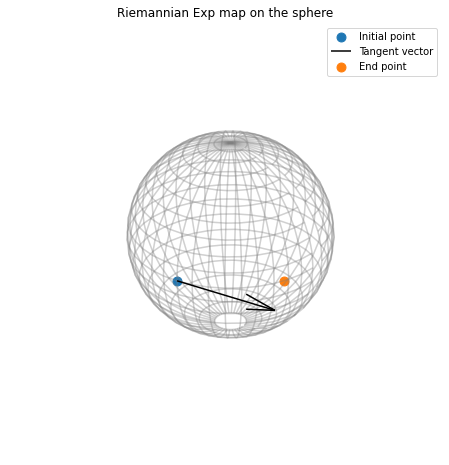

In [3]:
# Riemannian exp map of a tangent vector at a point
point_a = gs.array([gs.pi / 2.0, -gs.pi / 2.0])
tangent_vec = gs.array([0.0, gs.pi / 3.0])

end_point = sphere_metric.exp(tangent_vec=tangent_vec, base_point=point_a)
print(end_point)

# visualize the result of the Riemannian exp map in the embedding space
immersed_point_a = sphere_immersion(point_a)
immersed_tangent_vec = gs.matmul(jac_sphere_immersion(point_a), tangent_vec)
immersed_end_point = sphere_immersion(end_point)

# plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

viz.plot(immersed_point_a, ax=ax, space="S2", label="Initial point", s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

viz.plot(immersed_end_point, ax=ax, space="S2", label="End point", s=80)

ax.set_title("Riemannian Exp map on the sphere")
ax.legend()
ax.grid(False)
plt.axis("off");

[-0.5400031   0.48768765]


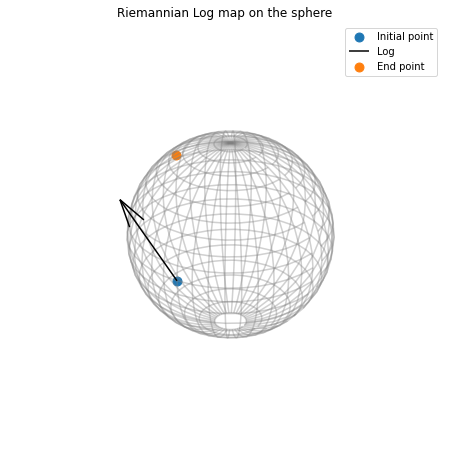

In [4]:
# Riemannian log map of two points
point_a = gs.array([gs.pi / 2.0, -gs.pi / 2.0])
point_b = gs.array([gs.pi / 3.0, -gs.pi / 3.0])

end_point = sphere_metric.log(point_b, base_point=point_a)
print(end_point)

# visualize the result of the Riemannian log map in the embedding space
immersed_point_a = sphere_immersion(point_a)
immersed_end_point = sphere_immersion(end_point)

# plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

viz.plot(immersed_point_a, ax=ax, space="S2", label="Initial point", s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_end_point)
arrow.draw(ax, color="black", label="Log")

viz.plot(immersed_end_point, ax=ax, space="S2", label="End point", s=80)

ax.set_title("Riemannian Log map on the sphere")
ax.legend()
ax.grid(False)
plt.axis("off");

# IV. Demonstration and Analysis

In [5]:
# understand the data
data = np.load("03_rat_skulls.npy")
data_first = data[:8]
print(f"The data of the first rat has shape (n_times, n_landmarks, dim)={data_first.shape}.")

The data of the first rat has shape (n_times, n_landmarks, dim)=(8, 8, 2).


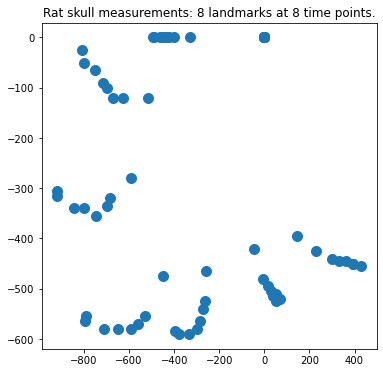

In [6]:
# plot of data
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
points = data_first.reshape(-1, 2)
plt.plot(points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull measurements: 8 landmarks at 8 time points.");

In [7]:
# define the preshape space and compute the Frechet mean  
preshape = PreShapeSpace(k_landmarks=8, m_ambient=2)
kendall_metric = KendallShapeMetric(k_landmarks=8, m_ambient=2)

mean = FrechetMean(metric=kendall_metric, point_type="matrix")

In [8]:
# split into train/test sets
X = np.linspace(0., 1., 8); X = np.atleast_2d(X).T
y = preshape.projection(data_first)
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"The dataset has {len(X)} skulls.")
print(f"The train set has {len(X_train)} skulls.")
print(f"The test set has {len(X_test)} skulls.")

The dataset has 8 skulls.
The train set has 6 skulls.
The test set has 2 skulls.


In [9]:
# consider the tangent space and compute the logarithms
mean.fit(y_train)

tangent_y_train = kendall_metric.log(y_train, base_point=mean.estimate_)
tangent_y_test = kendall_metric.log(y_test, base_point=mean.estimate_)

In [10]:
# fit a linear regression model and compute R^2
lr = LinearRegression()

lr.fit(X_train, tangent_y_train.reshape((6, -1)))

score = lr.score(X_test, tangent_y_test.reshape((2, -1)))

print(f"R^2 score: {score:.2f}.")

R^2 score: -4.97.


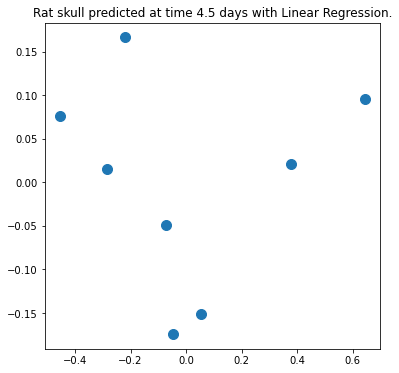

In [11]:
# predict the value at 4.5 days
tangent_skull = lr.predict(np.array([[4.5]]))

fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(111)
points = kendall_metric.exp(tangent_skull.reshape(-1, 2), base_point=mean.estimate_)
plt.plot(points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull predicted at time 4.5 days with Linear Regression.");

In [12]:
# fit a random forest regression model and compute R^2
rfr = RandomForestRegressor()

rfr.fit(X_train, tangent_y_train.reshape((6, -1)))

score = rfr.score(X_test, tangent_y_test.reshape((2, -1)))

print(f"R^2 score: {score:.2f}.")

R^2 score: -1.58.


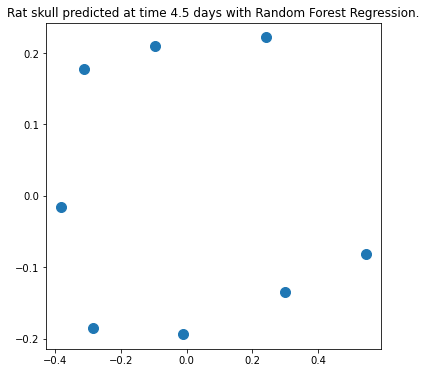

In [13]:
# predict the value at 4.5 days
tangent_skull =  rfr.predict(np.array([[4.5]]))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
points = kendall_metric.exp(tangent_skull.reshape(-1, 2), base_point=mean.estimate_)
plt.plot(points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull predicted at time 4.5 days with Random Forest Regression.");

In [14]:
# fit a polynomial regression model for degrees 0-3 and compute R^2
for k in range(4):
    print(f"k = {k}")
    polynomial_features = PolynomialFeatures(degree=k)
    X_poly = polynomial_features.fit_transform(X_train)
    lr = LinearRegression()
    lr.fit(X_poly, tangent_y_train.reshape((6, -1)))
    score = lr.score(polynomial_features.fit_transform(X_test), tangent_y_test.reshape((2, -1)))
    print(f"R^2 score: {score:.2f}.")
    print("--")

k = 0
R^2 score: -2.74.
--
k = 1
R^2 score: -4.97.
--
k = 2
R^2 score: -3.45.
--
k = 3
R^2 score: -0.72.
--


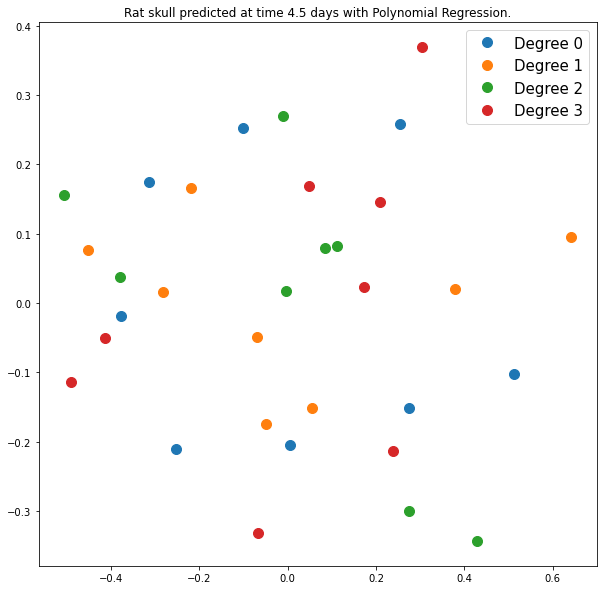

In [15]:
# predict the value at 4.5 days for degrees 0-3 
fig = plt.figure(figsize=(10, 10))

for k in range(4):
    polynomial_features = PolynomialFeatures(degree=k)
    X_poly = polynomial_features.fit_transform(X_train)
    lr = LinearRegression()
    lr.fit(X_poly, tangent_y_train.reshape((6, -1)))
    sample = polynomial_features.fit_transform(np.array([[4.5]]))
    tangent_skull = lr.predict(sample)
    
    points = kendall_metric.exp(tangent_skull.reshape(-1, 2), base_point=mean.estimate_)
    plt.plot(points[:, 0], points[:, 1], 'o', markersize=10, label='Degree '+str(k))
    plt.legend(prop={'size': 15})
   
plt.title("Rat skull predicted at time 4.5 days with Polynomial Regression.");

In [16]:
# fit a geodesic regression model and compute R^2
gr = GeodesicRegression(
    space=preshape, metric=kendall_metric, 
    center_X=False, method="riemannian", initialization="warm_start")

# Warm-start
gr.intercept_ = y_train[0]  # theta0
gr.coef_ = kendall_metric.log(y_train[-1], y_train[0]) # theta1

gr.fit(np.squeeze(X_train), y_train)

print('R^2:', gr.score(np.squeeze(X_test), y_test))

R^2: 0.5939307985898926


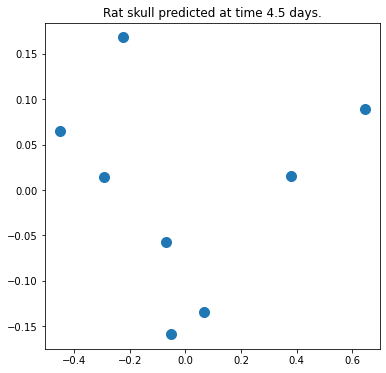

In [17]:
# predict the value at 4.5 days
skull =  gr.predict(np.array([4.5]))
fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(111)
points = skull.reshape(-1, 2)
plt.plot(points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull predicted at time 4.5 days.");

# Conclusion

After defining the tangent space with the Frechet mean, I applied multiple algorithms. The results are as follows:


                                Model | R^2 score
                                -----------------
                    Linear Regression | -4.97
             Random Forest Regression | -1.58
      Polynomial (deg = 0) Regression | -2.74
      Polynomial (deg = 1) Regression | -4.97
      Polynomial (deg = 2) Regression | -3.45
      Polynomial (deg = 3) Regression | -0.72
                  Geodesic Regression | 0.594
      
All the models had pretty bad $ R^2 $ scores, except for geodesic regression. Polynomial regression of degree 3 had the best score out of the rest, while linear regression performed the worst. This goes to show that the data cannot be fit using a linear trend, and is best represented using a polynomial function. 

The paper found that polynomial regression performed better than geodesic regression. Although that is not what happened in this demonstration, we are able to see that cubic regression shows some improvement as compared to increasing degrees. Not much is gained by further increasing the order of the polynomial, as the model starts to overfit.

# References

Hinkle, J., Muralidharan, P., Fletcher, P. T., & Joshi, S. (2012, October). Polynomial regression on Riemannian manifolds. In European conference on computer vision  (pp. 1-14). Springer, Berlin, Heidelberg.

https://github.com/geomstats/geomstats/blob/master/notebooks/09_practical_methods__implement_your_own_riemannian_geometry.ipynb

https://github.com/bioshape-lab/ece594n/blob/main/lectures/03_c_regression.ipynb

https://towardsdatascience.com/polynomial-regression-bbe8b9d97491